In [3]:
#Import libraries

import numpy as np
import pandas as pd 
import re
import string
import nltk

#Import the data 

#Function to import the data from the txt file using regex
def load_data(path):
    sentences = []
    labels = []

    with open(path, 'r', encoding='latin-1') as file:
        for line in file:
            match = re.match(r'^(.*)\.@(\w+)$', line)  #Data is in txt format so we are using regex to get the sentence and labels
            if match:
                sentence, label = match.groups()
                sentences.append(sentence)
                labels.append(label.lower())

    return pd.DataFrame({'text': sentences, 'label': labels})

#Call the function to load the data from txt
df = load_data('../Data/Sentences_AllAgree.txt')

#Print first 5 rows
df.head()

,text,label
0,"According to Gran , the company has no plans t...",neutral
1,"For the last quarter of 2010 , Componenta 's n...",positive
2,"In the third quarter of 2010 , net sales incre...",positive
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive


In [4]:
# categorical labels

cat_map = {'positive': 2, 'neutral':1, 'negative': 0}
df['label'] = df['label'].map(cat_map)

#Print first 5 rows
df.head()

,text,label
0,"According to Gran , the company has no plans t...",1
1,"For the last quarter of 2010 , Componenta 's n...",2
2,"In the third quarter of 2010 , net sales incre...",2
3,Operating profit rose to EUR 13.1 mn from EUR ...,2
4,"Operating profit totalled EUR 21.1 mn , up fro...",2


In [5]:
#Text Preprocessing

#Download if not available
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

#Import libraries
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#Remove stop words and punctuations
stop_word = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


#Function to process
def preprocess(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text) #Remove digits
    text = text.translate(str.maketrans('', '', string.punctuation))

    #Tokenize the text
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_word]
    return ' '.join(tokens)

#Call the function
df['clean_text'] = df['text'].apply(preprocess)

#Print first 5 rows
df.head()

,text,label,clean_text
0,"According to Gran , the company has no plans t...",1,according gran company plan move production ru...
1,"For the last quarter of 2010 , Componenta 's n...",2,last quarter componenta net sale doubled eurm ...
2,"In the third quarter of 2010 , net sales incre...",2,third quarter net sale increased eur mn operat...
3,Operating profit rose to EUR 13.1 mn from EUR ...,2,operating profit rose eur mn eur mn correspond...
4,"Operating profit totalled EUR 21.1 mn , up fro...",2,operating profit totalled eur mn eur mn repres...


In [11]:
#Import libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt

#Define feature and target

X = df['clean_text']
y = df['label']


#Train test split
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


Evaluating SVM Pipeline
              precision    recall  f1-score   support

    Negative       0.84      0.53      0.65        59
     Neutral       0.87      0.97      0.91       272
    Positive       0.78      0.72      0.75       111

    accuracy                           0.85       442
   macro avg       0.83      0.74      0.77       442
weighted avg       0.84      0.85      0.84       442

Confusion Matrix:


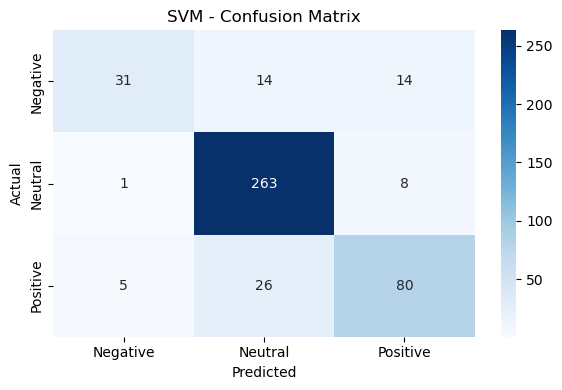

SVM CV Accuracy: 0.8256

Evaluating Naive Bayes Pipeline
              precision    recall  f1-score   support

    Negative       1.00      0.03      0.07        59
     Neutral       0.81      0.97      0.88       272
    Positive       0.63      0.63      0.63       111

    accuracy                           0.76       442
   macro avg       0.81      0.55      0.53       442
weighted avg       0.79      0.76      0.71       442

Confusion Matrix:


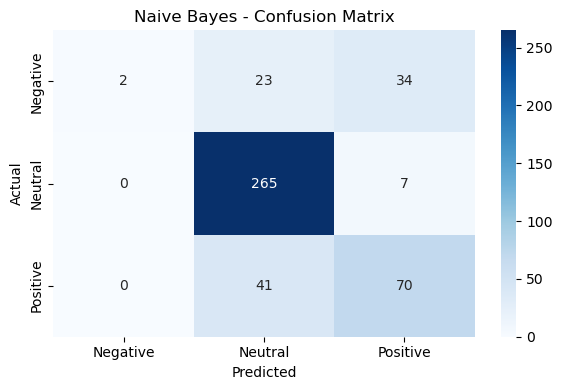

Naive Bayes CV Accuracy: 0.7707

Evaluating Random Forest Pipeline
              precision    recall  f1-score   support

    Negative       0.77      0.46      0.57        59
     Neutral       0.85      0.97      0.91       272
    Positive       0.79      0.69      0.74       111

    accuracy                           0.83       442
   macro avg       0.81      0.71      0.74       442
weighted avg       0.83      0.83      0.82       442

Confusion Matrix:


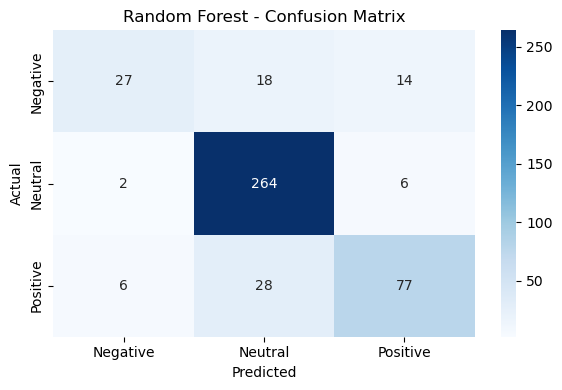

Random Forest CV Accuracy: 0.8239

Evaluating MLP Classifier Pipeline
              precision    recall  f1-score   support

    Negative       0.65      0.59      0.62        59
     Neutral       0.90      0.92      0.91       272
    Positive       0.75      0.74      0.74       111

    accuracy                           0.83       442
   macro avg       0.76      0.75      0.76       442
weighted avg       0.82      0.83      0.83       442

Confusion Matrix:


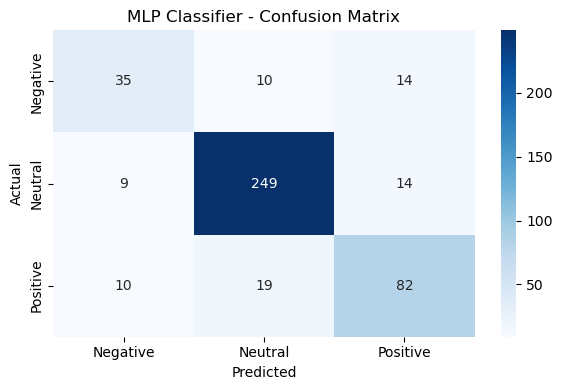

MLP Classifier CV Accuracy: 0.8182


In [14]:

from sklearn.neural_network import MLPClassifier
#Using TFIDF with modeling pipeline 
svm_pipeline = make_pipeline(TfidfVectorizer(max_features=5000), SVC(kernel='linear'))
nb_pipeline = make_pipeline(TfidfVectorizer(max_features=5000), MultinomialNB())
rf_pipeline = make_pipeline(TfidfVectorizer(max_features=5000), RandomForestClassifier(n_estimators=100, random_state=42))

# Add MLP pipeline
mlp_pipeline = make_pipeline(TfidfVectorizer(max_features=5000), 
                             MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42))

labels = ['Negative', 'Neutral', 'Positive']

# Run all pipelines in a loop
for name, pipeline in [("SVM", svm_pipeline), ("Naive Bayes", nb_pipeline), ("Random Forest", rf_pipeline), ("MLP Classifier", mlp_pipeline)]:
    print(f"\nEvaluating {name} Pipeline")
    
    # Fit on training data
    pipeline.fit(X_train, y_train)

    # Predict on test data
    y_pred = pipeline.predict(X_test)

    # Print classification report
    print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

    # Confusion matrix
    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    # Plot
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    # Cross-validation score
    cv_score = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
    print(f"{name} CV Accuracy: {cv_score.mean():.4f}")
    print("="*60)